In [1]:
%load_ext autoreload
%autoreload 2

In [1456]:
%matplotlib inline

import sys
sys.path.append('../src/')

import glob
import warnings

import numpy as np
import pandas as pd
import xarray as xr

from scipy.optimize import curve_fit, minimize

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray

from sklearn.linear_model import LinearRegression

from epsilon_tools import *
from tools import str2date, avg_funs, integrate_columns, first_finite, bandpass_velocity, interp_in_space
from qc import qc_turbulence

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='poster', palette='colorblind')
mpl.rc('figure', dpi=100, figsize=[12, 6])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)


sns.set(style="ticks", context="talk")
# plt.style.use("dark_background")

In [1658]:
def qc_velocity(data):
    '''
    qc EM velocity measurements based on vertical movement and rotation rate of the float
    '''
    Wmin = 0.05
    RotPmax = 20
    verrmax = 0.1 # original 0.02

    # where cond:  what to keep!
    uv_mask = (np.abs(data.W) > Wmin) & (data.RotP < RotPmax)
    u1_mask = uv_mask & (data.verr1 < verrmax)
    u2_mask = uv_mask & (data.verr2 < verrmax)

    data['u1'] = data.u1.where(u1_mask)
    data['u2'] = data.u2.where(u2_mask)
    data['v1'] = data.v1.where(u1_mask)
    data['v2'] = data.v2.where(u2_mask)

    data['u'] = avg_funs(data['u1'], data['u2'])
    data['v'] = avg_funs(data['v1'], data['v2'])
    data['dudz'] = avg_funs(data['du1dz'], data['du2dz'])
    data['dvdz'] = avg_funs(data['dv1dz'], data['dv2dz'])
    data['S2'] = 0.5*( data.dudz**2 + data.dvdz**2 )

    data = data.drop([
        'W', 'RotP', 'verr1', 'verr2', 'u1', 'u2', 'v1', 'v2', 'du1dz',
        'du2dz', 'dv1dz', 'dv2dz'
    ])
    return data

In [1659]:
floatid = '7781a'
raw = xr.open_dataset(f'../data/xarray/xr_{floatid}.nc')
cfs = xr.open_dataset('../data/metdata/float_cfs_hourly.nc')
cfs = cfs.sel(floatid=f'{floatid}')
emp = xr.open_dataset('../data/CFS/croppped_emp_field.nc')
raw = qc_turbulence(raw)
raw = qc_velocity(raw)

In [1646]:
from tools import load_matfile, datenum2datetime
dn2dt_vec = np.vectorize(lambda x: datenum2datetime(x))

In [1682]:
met = xr.open_dataset('../data/CFS/CFSv2_wind_rh_t_p_2016_2018.nc')

In [1685]:
met

<xarray.Dataset>
Dimensions:  (lat: 98, lon: 245, time: 2548)
Coordinates:
  * lat      (lat) float32 49.982952 49.778522 49.574097 ... 30.357746 30.153316
  * lon      (lon) float32 130.09091 130.29546 130.5 ... 179.79546 180.0
  * time     (time) datetime64[ns] 2016-08-01 ... 2018-04-29T18:00:00
Data variables:
    pres     (lon, lat, time) float64 ...
    temp     (lon, lat, time) float64 ...
    u10      (lon, lat, time) float64 ...
    v10      (lon, lat, time) float64 ...
    wspeed   (lon, lat, time) float64 ...

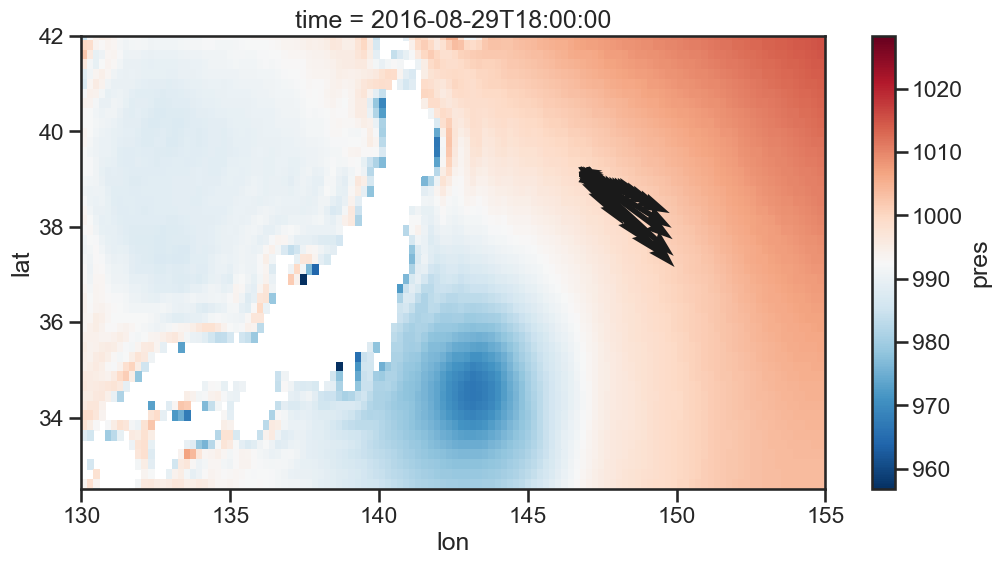

In [1703]:
met.pres.interp(time='2016-08-29T18:00:00').plot(x='lon', cmap='RdBu_r')
temp = cfs.sel(time=slice('2016-08-28T18:00:00','2016-08-31T18:00:00'))
plt.quiver(temp.lon,temp.lat, temp.tx, temp.ty)
plt.xlim(130,155)
plt.ylim(32.5,42);

In [1647]:
oc = load_matfile('../data/CFS/CFSv2_ocn_uv_t2m_2016_2018.mat')

In [1648]:
oc['u_ocn'].shape

(60, 40, 14593)

In [1649]:
dsoc = xr.Dataset({  # define wanted variables here!
        'u': (['lon', 'lat', 'time'], oc['u_ocn']),
        'v': (['lon', 'lat', 'time'], oc['v_ocn']),
    },
        coords={'lon': oc['Lon_ocn'], 'lat':oc['Lat_ocn'],
                'time': dn2dt_vec(oc['Jday_gmt_ocn'])}
    )

In [1626]:
dsoc = dsoc.sel(time=slice('2016-10-01','2016-10-21'))

In [1634]:
atmnew = atm.interp_like(dsoc)

In [1635]:
tot = xr.merge([atmnew, dsoc])

In [1396]:
atm = xr.open_dataset('../data/CFS/CFSv2_wind_rh_t_p_2016_2018.nc').sel(time=slice('2016-10-01','2016-10-21'))

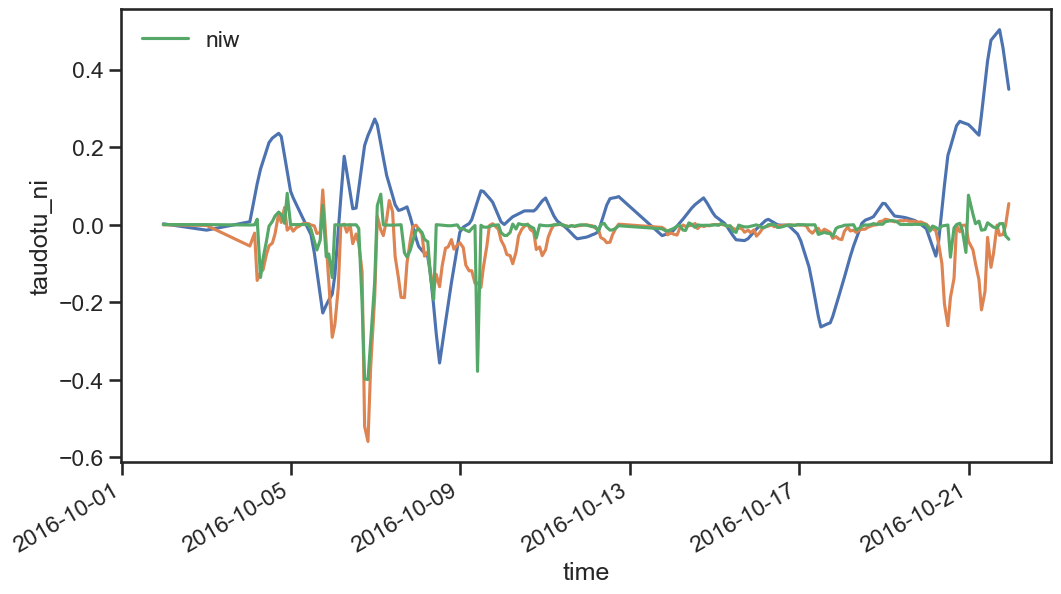

In [1676]:
subset.ty.plot()
subset.taudotu.plot()
raw.sel(time=slice('2016-10-01','2016-10-21')).taudotu_ni.pipe(lambda x: 10*x).plot(label='niw')
plt.legend()

In [1421]:
atm['phase'] = np.arctan2(atm.v10,atm.u10)

In [1448]:
atm['dphase'] = atm.phase.differentiate('time', datetime_unit='s')

In [1457]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [1464]:
def plot_2d(t):
    atm.dphase.isel(time=t).transpose().plot()
    plt.plot(subset.lon,subset.lat, marker='d', markersize=5, color='r')

In [1556]:
import holoviews as hv

In [1570]:
f = gsw.f(40)

In [1677]:
atm.phase.hvplot(x='lon', y='lat', width=500, height=500)+atm.dphase.pipe(lambda x: x/f).hvplot(x='lon', y='lat',cmap='RdBu_r', size=10, width=500, height=500)

:Layout
   .DynamicMap.I  :DynamicMap   [time]
      :Image   [lon,lat]   (phase)
   .DynamicMap.II :DynamicMap   [time]
      :Image   [lon,lat]   (dphase)

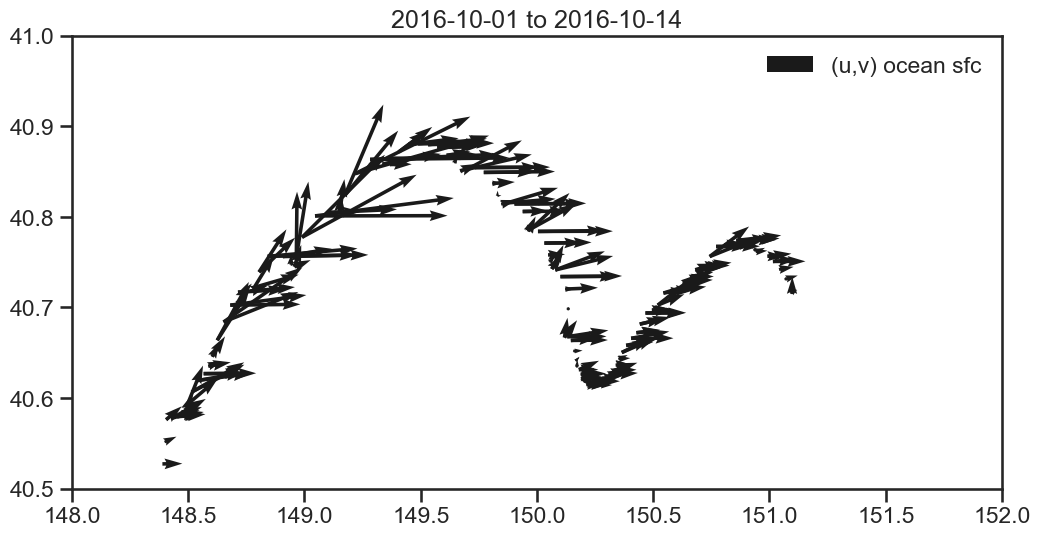

In [1723]:
ang = np.arctan2(subset.v_surf,subset.u_surf)
plt.quiver(subset.lon,subset.lat, subset.u_surf, subset.v_surf, label='(u,v) ocean sfc')
# plt.plot(subset.lon.isel(time=20),subset.lat.isel(time=20), marker='o', markersize=10)
# plt.quiver(subset.lon,subset.lat, -subset.tx, -subset.ty, color='green', alpha=0.2, label=r'(-$\tau_x$,-$\tau_y$)')
# plt.quiver(subset.lon,subset.lat, subset.tx, subset.ty, color='red', alpha=0.2, label=r'($\tau_x$,$\tau_y$)')

temp = cfs.sel(time=slice('2016-10-01','2016-10-21'))
# plt.quiver(temp.lon,temp.lat, temp.tx, temp.ty)

plt.ylim(40.5,41)
plt.xlim(148,152)
plt.title('2016-10-01 to 2016-10-14')
plt.legend()

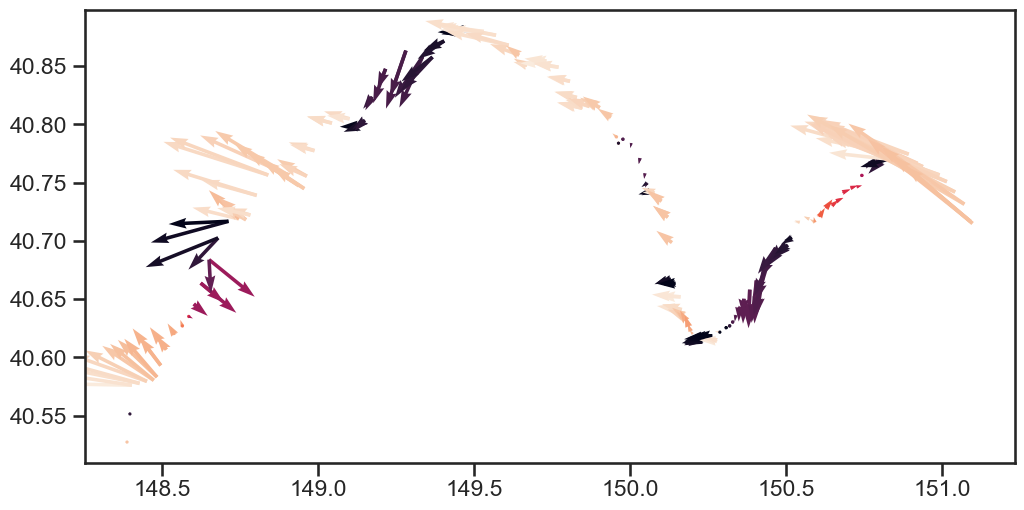

In [1495]:
ang = np.arctan2(subset.ty, subset.tx)
plt.quiver(subset.lon,subset.lat, subset.tx, subset.ty, ang)

In [1666]:
def first_finite(arr, axis):
    '''spits out the indices'''
    mask = arr.notnull() & (arr > 0)
    return xr.where(mask.any(axis=axis), mask.argmax(axis=axis), np.nan).fillna(0).astype(int)

In [1667]:
raw['mld'] = ('time', raw.z.where(raw.S2 == raw.S2.max(dim='z')).mean(dim='z'))
raw['Ri'] = raw.n2/raw.S2

# extract uppermost velocity measuremnt
indu = first_finite(raw.u, 0).fillna(0).astype(int)
indv = first_finite(raw.v, 0).fillna(0).astype(int)

raw['u_surf'] = raw.u[indu]
raw['v_surf'] = raw.v[indv]



indS = first_finite(raw.S, 0).fillna(0).astype(int)
indT = first_finite(raw.T, 0).fillna(0).astype(int)
raw['S_surf'] = 0.5*(raw.S[indS]+raw.S[indS+1])
raw['T_surf'] = 0.5*(raw.T[indT]+raw.T[indT+1])

In [1668]:
emp = emp.sortby('time').resample(time='1h').mean()
emp = emp.interp_like(raw) # interpolates onto floats time
cfs = cfs.interp_like(raw, method='linear')
rho0=raw.rho0.mean()
g = 9.81

uNI, vNI = bandpass_velocity(raw)
raw['uNI'] = uNI.drop('dtime')
raw['vNI'] = vNI.drop('dtime')
raw['hkeNI'] = 0.5*rho0*( raw.uNI**2 + raw.vNI**2)
raw['hkeTOT'] = 0.5*rho0*( raw.u**2 + raw.v**2)

# extract uppermost velocity measuremnt
indu = first_finite(raw.uNI, 0).fillna(0).astype(int)
indv = first_finite(raw.vNI, 0).fillna(0).astype(int)
raw['u_surf_ni'] = raw.uNI[indu]
raw['v_surf_ni'] = raw.vNI[indv]

raw['emp'] = ('time', interp_in_space(raw, emp).EMP)
raw['emp'] = raw.emp/(100*86400)
raw['qnet'] = ('time', cfs['Qnet'])
                                                                                    
raw['tx'] = ('time', cfs['tx'])
raw['ty'] = ('time', cfs['ty'])
raw['taudotu'] = raw.u_surf * raw.tx + raw.v_surf * raw.ty
raw['taudotu_ni'] = raw.u_surf_ni * raw.tx + raw.v_surf_ni * raw.ty

raw['tau'] = ('time', np.sqrt( raw.tx**2 + raw.ty**2 ))
raw['uprime'] = np.sqrt( raw.tau/raw.rho0.mean() )
raw['shear_prod'] = -raw.uprime**3/(0.4*raw.z) 
raw['shear_prod'] = raw.shear_prod.transpose('z','time').where( raw.shear_prod<1e5)
# raw['mshear_prod'] = ('time', -integrate_columns(raw.shear_prod, raw.mld))

../src/tools.py:97: UnevenSamplingWarning: Average sampling 9.94e+12 != first sampling step 2.23e+12
  fs = ( dsp.get_sampling_step(raw, dim='time')*1e-9 )


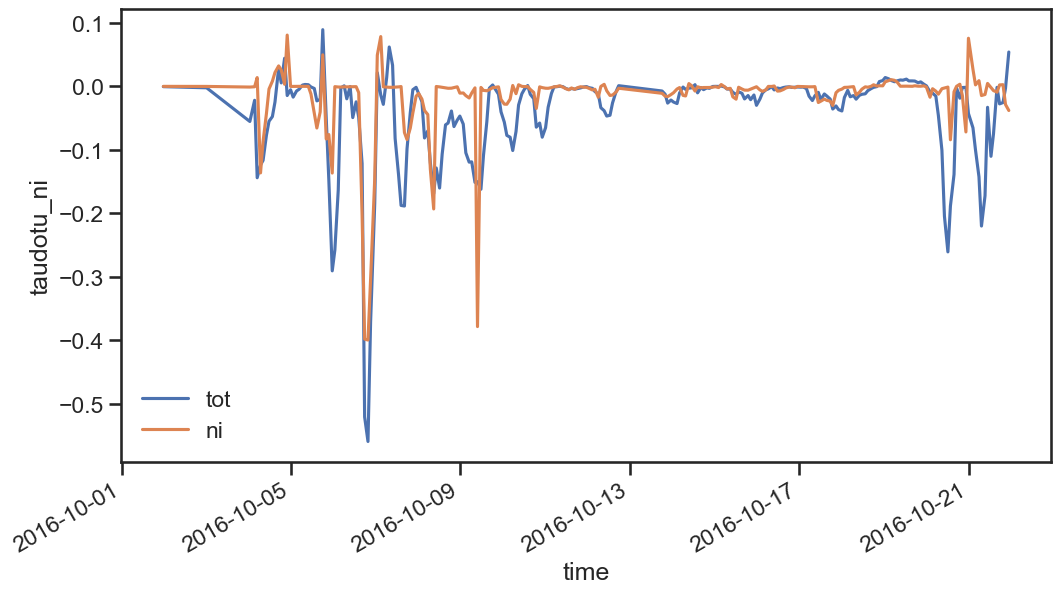

In [1669]:
raw.taudotu.sel(time=slice('2016-10-01','2016-10-21')).plot(label='tot')
raw.taudotu_ni.pipe(lambda x: x*10).sel(time=slice('2016-10-01','2016-10-21')).plot(label='ni')
plt.legend()

In [1328]:
import gsw
cp = gsw.cp_t_exact(raw.S_surf.mean(),raw.T_surf.mean(),0)
alphaT = gsw.alpha(raw.S_surf.mean(),raw.T_surf.mean(),0)
betaS = gsw.beta(raw.S_surf.mean(),raw.T_surf.mean(),0)

raw['BQ'] = (g*alphaT*raw.qnet/(cp*rho0))
raw['BEP'] = (g*betaS*raw.emp*raw.S_surf/(1-raw.S_surf/1000))
raw['B'] = (raw.BQ + raw.BEP)

In [1181]:
raw['rho_ref'] = raw.rho0.rolling(time=10).mean(dim='time')
raw['rho_prime'] = raw.rho0 - raw.rho_ref

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Reductions will be applied along the rolling dimension 'time'. Passing the 'dim' kwarg to reduction operations has no effect and will raise an error in xarray 0.16.0.
  """Entry point for launching an IPython kernel.


## Available potential energy
$ APE = g\int_{z-\eta}^z [\rho(z) - \rho_r(z')] dz' $\
where $\rho_r$ is the reference density and $\eta$ the vertical displacement of a fluid particle.

![Schematic from Kang](../figures/ape_schematic.png)

## Try on one profile:

In [980]:
prof = raw.isel(time=200)
prof = prof.dropna(dim='z', how='all', subset=['rho_ref'])

In [985]:
# make rho the coordinate
proff = prof.swap_dims({'z':'rho_ref'})
# # depth of parcel with certain density
# z2 = prof.rho0.isel(z=100).z
# # depth that a parcel with certain density would have in the reference state
# z1 = proff.interp(rho_ref=prof.rho0.isel(z=100)).z
# get z's for the whole profile
prof['zref'] = ('z', proff.interp(rho_ref=prof.rho0.values).z)

In [989]:
def integral(data,z1,z2):
    if z2>z1:
        data = data.where( (data.z >= z1) & (data.z <= z2) ) # this is a problem because sometimes it will be the opposite order
        sign= -1
    else:
        data = data.where( (data.z >= z2) & (data.z <= z1) )
        sign= 1
    data['z'] = data.z * (-1)*sign
    array = []
    return data.dropna('z').integrate('z')

In [990]:
def compute_ape(ds):
    liste=[]
    for i,z in enumerate(ds.z):
        liste.append( 9.81*integral(ds.rho_prime,z,ds.zref.isel(z=i)) )
    return xr.concat( liste, dim='z')

In [ ]:
prof['ape'] = ('z', compute_ape(prof) )

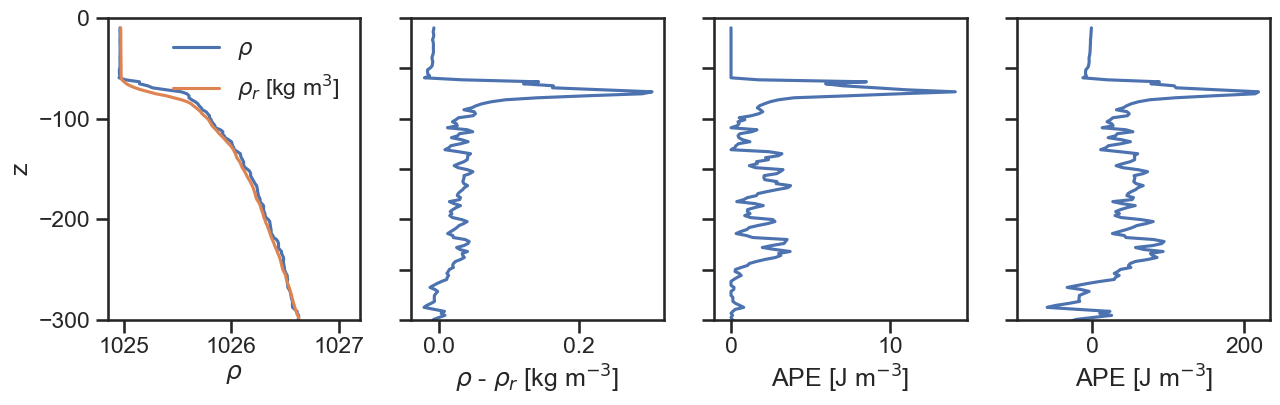

In [1322]:
fig = plt.figure(figsize=(15,4))

zmin= -300

ax = fig.add_subplot(1,4,1)
prof.rho0.plot(y='z', ax= ax,label=r'$\rho$')
prof.rho_ref.plot(y='z', ax= ax,label=r'$\rho_r$ [kg m$^3$]')
ax.set_title(None)
ax.legend()
ax.set_xlabel(r'$\rho$')
ax.set_yticks(np.arange(-600,1,100))
ax.set_ylim(zmin,0)

ax = fig.add_subplot(1,4,2)
prof.rho_prime.plot(y='z', ax= ax)
ax.set_xlabel(r'$\rho$ - $\rho_r$ [kg m$^{-3}$]')
ax.set_title(None)
ax.set_yticklabels([])
ax.set_ylabel(None)
ax.set_ylim(zmin,0)

ax = fig.add_subplot(1,4,3)
prof.ape.plot(y='z', ax= ax)
ax.set_xlabel(r'APE [J m$^{-3}$]')
ax.set_yticklabels([])
ax.set_ylabel(None)
ax.set_title(None)
ax.set_ylim(zmin,0)

ax = fig.add_subplot(1,4,4)
(-prof.rho_prime*9.81*prof.z).plot(y='z', ax= ax)
ax.set_xlabel(r'APE [J m$^{-3}$]')
ax.set_yticklabels([])
ax.set_ylabel(None)
ax.set_title(None)
ax.set_ylim(zmin,0)

plt.subplots_adjust()

## Do it for the whole dataest

In [ ]:
# Do it for the whole dataest
array = []
for t in range(raw.time.size):
    # TODO: could do better here with simpson's rule
    prof = raw.isel(time=t)
    prof = prof.dropna(dim='z', how='all', subset=['rho_ref'])
    prof = prof[['rho_ref','rho0','rho_prime']]
    proff = prof.swap_dims({'z':'rho_ref'})
    if prof.rho_ref.size>0:
        prof['zref'] = ('z', proff.interp(rho_ref=prof.rho0.values).z)
        prof['ape'] = ('z', compute_ape(prof) )
        array.append(prof)
    else:
        array.append(np.nan)
        
cleanedList = [x for x in array if type(x)!=float]
new = xr.concat(cleanedList, dim='time')


In [1670]:
merge = xr.merge([new.transpose(),raw], compat='override')

In [1671]:
merge.to_netcdf('../data/xarray/7781a_ape.nc')

In [1672]:
subset = merge.sel(time=slice('2016-10-01','2016-10-21'))

In [1340]:
subset['hkeNI'] *= rho0

(-200, 0)

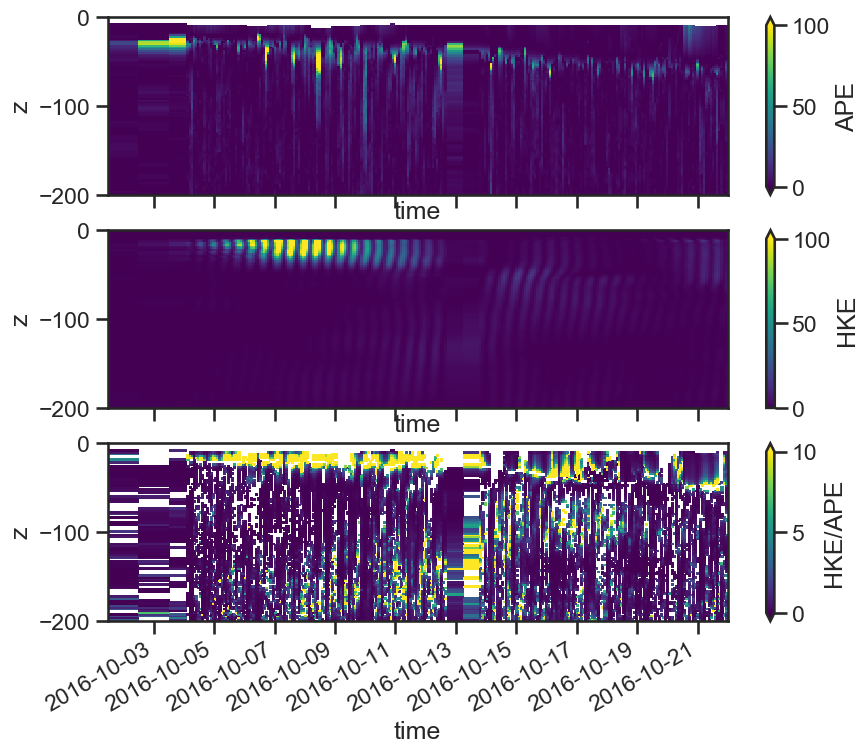

In [1341]:
f,ax = plt.subplots(3,1,figsize=(10,8), sharex=True)

subset.ape.plot(ax=ax[0],vmin=0,vmax=100, cbar_kwargs={'label':'APE'})
ax[0].set_ylim(-200,0)

subset.hkeNI.plot(ax=ax[1],vmin=0,vmax=100, cbar_kwargs={'label':'HKE'})
ax[1].set_ylim(-200,0)

(subset.hkeNI/subset.ape).plot(ax=ax[2], vmin=0, vmax=10, cbar_kwargs={'label':'HKE/APE'})
ax[2].set_ylim(-200,0)

In [1339]:
g=9.81
zmin=-300
subset['ape_ml'] = ('time', integrate_columns(subset.ape, subset.mld,0) ) # divide by 1000 to get kJ
subset['ape_py'] = ('time', integrate_columns(subset.ape, zmin, subset.mld))

subset['hke_ml'] = ('time', integrate_columns(subset.hkeNI, subset.mld,0))
subset['hke_py'] = ('time', integrate_columns(subset.hkeNI, zmin, subset.mld))

subset['eps_ml'] = ('time', integrate_columns(subset.eps, subset.mld,0))
subset['eps_py'] = ('time', integrate_columns(subset.eps, zmin, subset.mld))

# subset['hke_full'] = ('time', integrate_columns(subset.hke, zmin,0) )
# subset['ape_full'] = ('time', integrate_columns(subset.ape, zmin,0) )

# subset['ape_prime_ml'] = subset.ape_ml #- subset.ape_ml.isel(time=slice(0,10)).mean()
# subset['ape_prime_py'] = subset.ape_py #- subset.ape_py.isel(time=slice(0,10)).mean()

# subset['hke_prime_ml'] = subset.hke_ml #- subset.hke_ml.isel(time=slice(0,10)).mean()
# subset['hke_prime_py'] = subset.hke_py #- subset.hke_py.isel(time=slice(0,10)).mean()

In [1285]:
taudotu_series = subset.taudotu.to_series()
taudotu_positive = taudotu_series[taudotu_series>0]*3
tau_series = subset.tau.to_series()

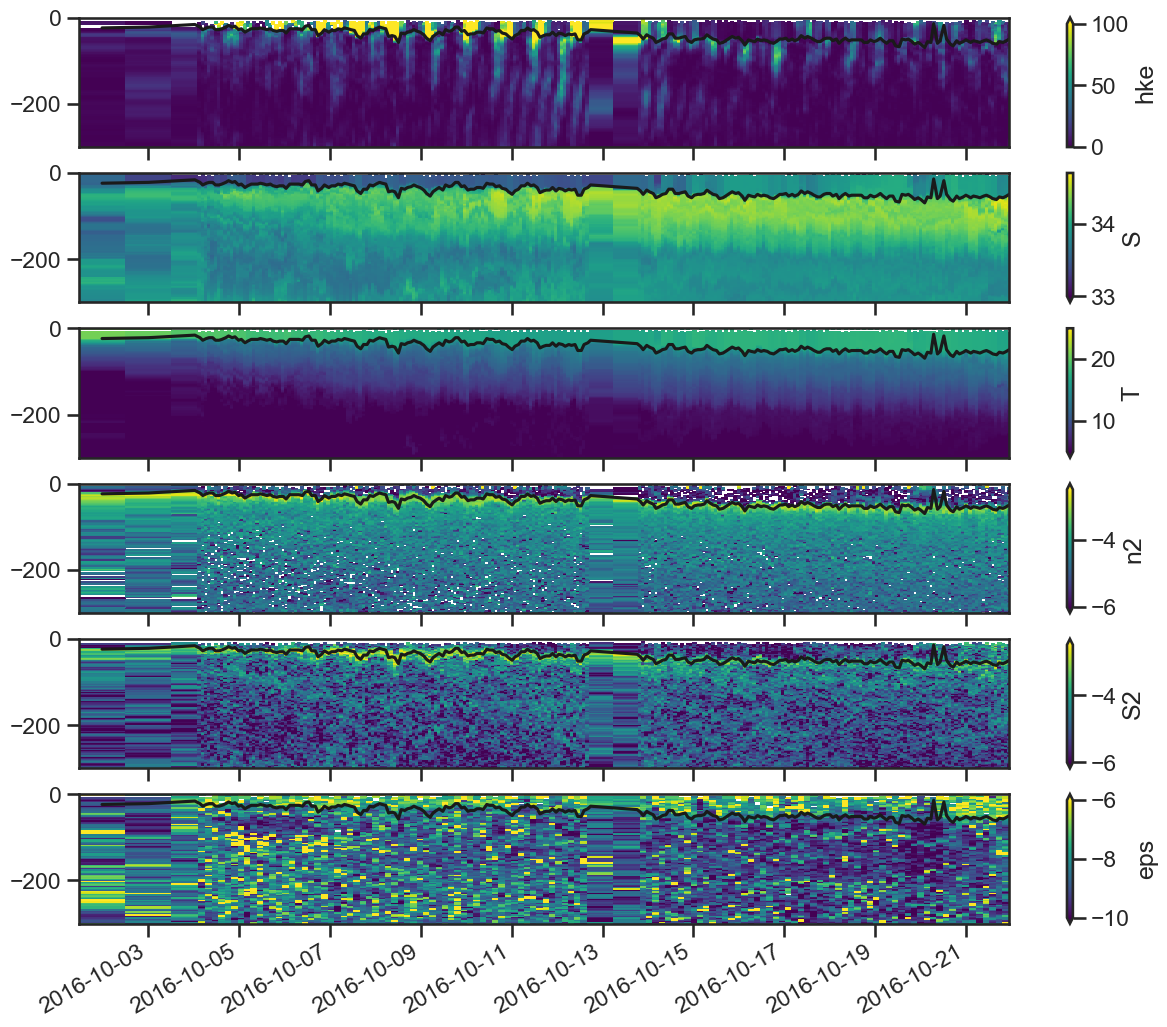

In [1287]:
zmin=-300
f,ax = plt.subplots(6,1,figsize=(15,12), sharex=True)

subset.hke.plot(vmin=0,vmax=100, ax=ax[0])
subset.mld.plot(color='k', ax=ax[0], label='HKE')
ax[0].set_ylim(zmin,0)
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)

subset.S.plot(vmin=33,vmax=34.7, ax=ax[1])
subset.mld.plot(color='k', ax= ax[1])
ax[1].set_ylim(zmin,0)
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)

subset.T.plot(vmin=5,vmax=25, ax=ax[2])
subset.mld.plot(color='k', ax= ax[2])
ax[2].set_ylim(zmin,0)
ax[2].set_xlabel(None)
ax[2].set_ylabel(None)

subset.n2.pipe(np.log10).plot(vmin=-6,vmax=-2.5, ax=ax[3])
subset.mld.plot(color='k', ax= ax[3])
ax[3].set_ylim(zmin,0)
ax[3].set_xlabel(None)
ax[3].set_ylabel(None)

subset.S2.pipe(np.log10).plot(vmin=-6,vmax=-2.5, ax=ax[4])
subset.mld.plot(color='k', ax=ax[4])
ax[4].set_ylim(zmin,0)
ax[4].set_xlabel(None)
ax[4].set_ylabel(None)

subset.eps.dropna(dim='time',how='all').pipe(np.log10).plot(vmin=-10,vmax=-6, ax=ax[5])
subset.mld.plot(color='k', ax= ax[5])
ax[5].set_ylim(zmin,0)
ax[5].set_xlabel(None)
ax[5].set_ylabel(None);


In [1335]:
subset['ape_ml_avg'] = subset['ape_ml'].rolling(time=9).mean()/1000
subset['ape_py_avg'] = subset['ape_py'].rolling(time=9).mean()/1000
subset['hke_ml_avg'] = subset['hke_ml'].rolling(time=9).mean()/1000
subset['hke_py_avg'] = subset['hke_py'].rolling(time=9).mean()/1000

KeyError: 'ape_ml'

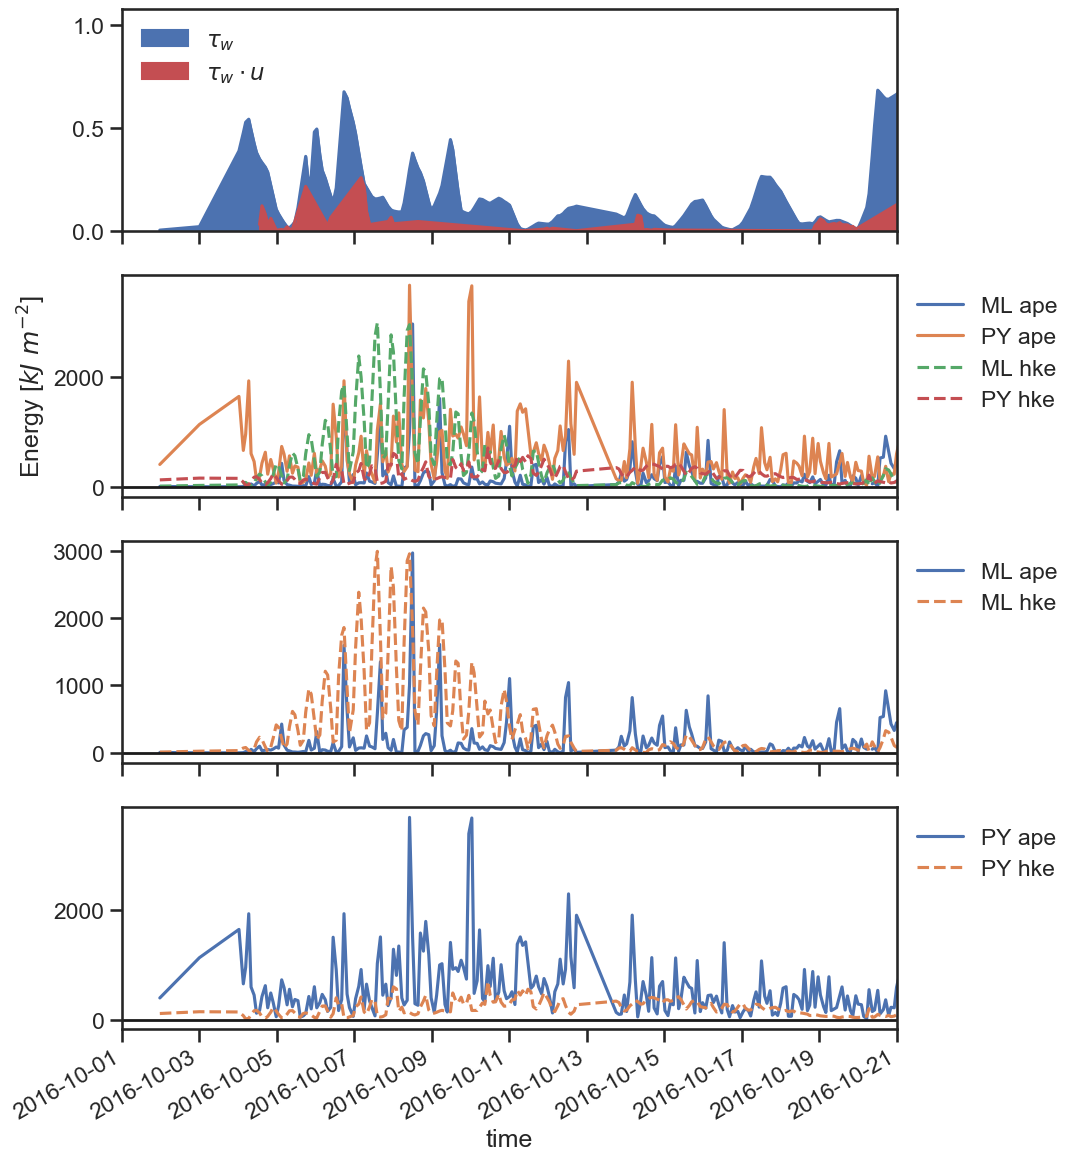

In [1291]:
f = plt.figure(figsize=(10,15))

nplots=4
ax = f.add_subplot(nplots,1,1)
tau_series.plot.area(color='b',ax=ax, label=r'$\tau_w$')
taudotu_positive.plot.area(color='r',ax=ax,label=r'$\tau_w \cdot u$')

ax.set_xticklabels([])
ax.set_xlabel(None)
ax.legend()
ax.set_xlim('2016-10-01','2016-10-21')

ax = f.add_subplot(nplots,1,2)
subset.ape_ml.plot(label=r'ML ape', ax=ax)
subset.ape_py.plot(label=r'PY ape', ax=ax)
subset.hke_ml.plot(label=r'ML hke',linestyle='dashed', ax=ax)
subset.hke_py.plot(label=r'PY hke',linestyle='dashed', ax=ax)

ax.axhline(0, color='k',lw=2)
ax.legend()
ax.set_ylabel('Energy [$kJ~m^{-2}$]');
ax.legend(loc='upper left', bbox_to_anchor=(1, 1));
ax.set_xlim('2016-10-01','2016-10-21')
ax.set_xticklabels([])
ax.set_xlabel(None)

ax = f.add_subplot(nplots,1,3)
# taudotu_positive.plot(color='r',ax=ax,label=r'$\tau_w \cdot u$')
subset.ape_ml.plot(label=r'ML ape', ax=ax)
subset.hke_ml.plot(label=r'ML hke',linestyle='dashed', ax=ax)
ax.set_ylabel(None)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1));
ax.axhline(0, color='k',lw=2);
ax.set_xlim('2016-10-01','2016-10-21');
ax.set_xticklabels([])
ax.set_xlabel(None)

ax = f.add_subplot(nplots,1,4)
# taudotu_positive.plot(color='r',ax=ax,label=r'$\tau_w \cdot u$')
subset.ape_py.plot(label=r'PY ape', ax=ax)
subset.hke_py.plot(label=r'PY hke',linestyle='dashed', ax=ax)
ax.set_ylabel(None)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1));
ax.axhline(0, color='k',lw=2);
ax.set_xlim('2016-10-01','2016-10-21');

plt.savefig('../figures/test.pdf')

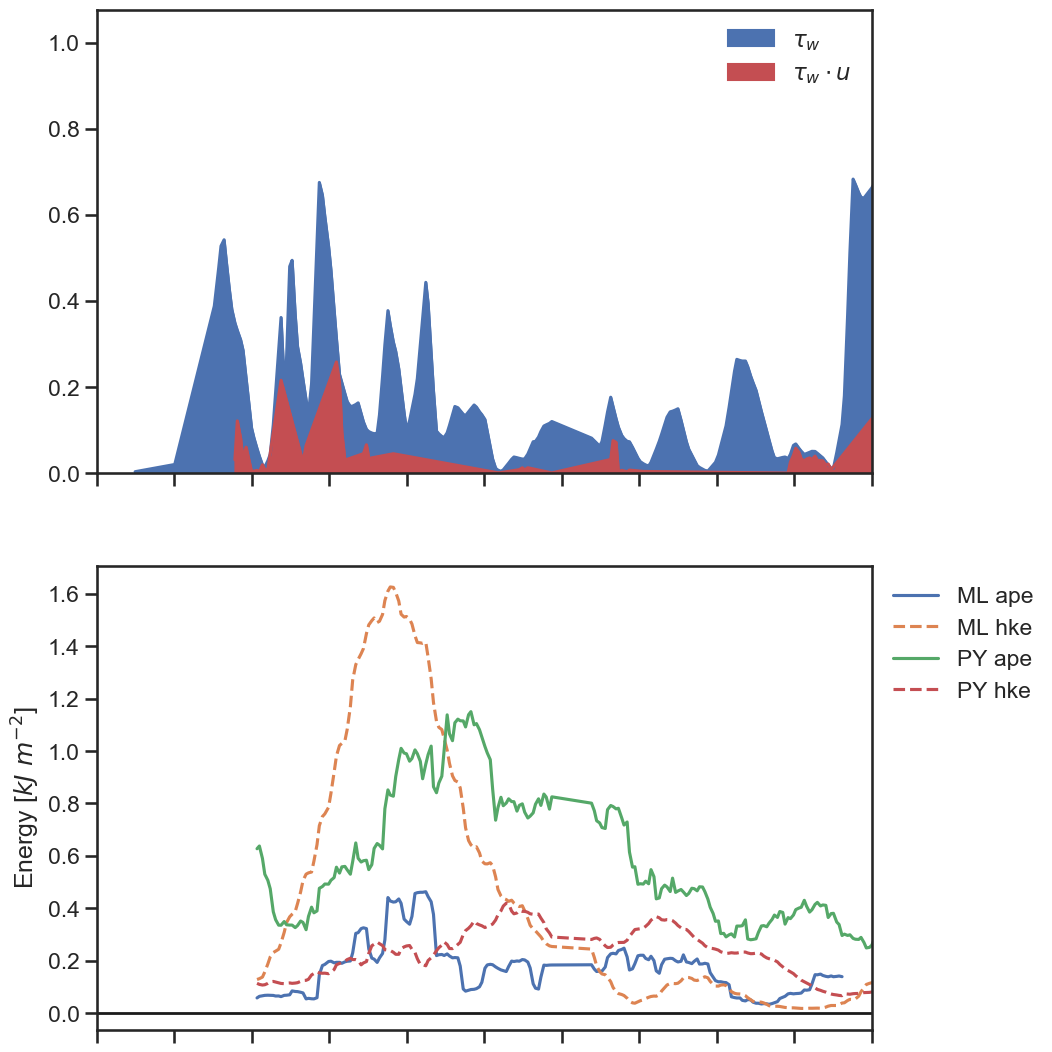

In [1300]:
f = plt.figure(figsize=(10,15))

nplots=2
ax = f.add_subplot(nplots,1,1)
tau_series.plot.area(color='b',ax=ax, label=r'$\tau_w$')
taudotu_positive.plot.area(color='r',ax=ax,label=r'$\tau_w \cdot u$')

ax.set_xticklabels([])
ax.set_xlabel(None)
ax.legend()
ax.set_xlim('2016-10-01','2016-10-21')

ax = f.add_subplot(nplots,1,2)
subset.ape_ml_avg.plot(label=r'ML ape', ax=ax)
subset.hke_ml_avg.plot(label=r'ML hke',linestyle='dashed', ax=ax)
subset.ape_py_avg.plot(label=r'PY ape', ax=ax)
subset.hke_py_avg.plot(label=r'PY hke',linestyle='dashed', ax=ax)

ax.axhline(0, color='k',lw=2)
ax.legend()
ax.set_ylabel('Energy [$kJ~m^{-2}$]');
ax.legend(loc='upper left', bbox_to_anchor=(1, 1));
ax.set_xlim('2016-10-01','2016-10-21')
ax.set_xticklabels([])
ax.set_xlabel(None)

# ax = f.add_subplot(nplots,1,3)
# # taudotu_positive.plot(color='r',ax=ax,label=r'$\tau_w \cdot u$')
# subset.ape_ml_avg.plot(label=r'ML ape', ax=ax)
# subset.hke_ml_avg.plot(label=r'ML hke',linestyle='dashed', ax=ax)
# ax.set_ylabel(None)
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1));
# ax.axhline(0, color='k',lw=2);
# ax.set_xlim('2016-10-01','2016-10-21');
# ax.set_xticklabels([])
# ax.set_xlabel(None)

# ax = f.add_subplot(nplots,1,4)
# # taudotu_positive.plot(color='r',ax=ax,label=r'$\tau_w \cdot u$')
# subset.ape_py_avg.plot(label=r'PY ape', ax=ax)
# subset.hke_py_avg.plot(label=r'PY hke',linestyle='dashed', ax=ax)
# ax.set_ylabel(None)
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1));
# ax.axhline(0, color='k',lw=2);
# ax.set_xlim('2016-10-01','2016-10-21');

plt.savefig('../figures/test.pdf')

(-1.815774528715342,
 0.3099297617809712,
 -1.2139155372779131,
 -0.331455602889153)

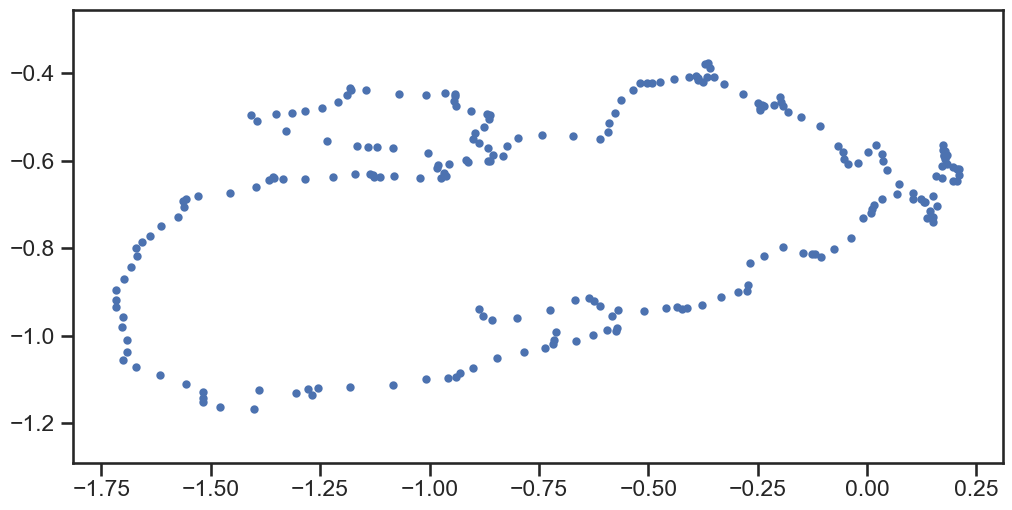

In [1321]:
plt.scatter(subset.hke_ml_avg.pipe(np.abs).pipe(np.log10),subset.hke_py_avg.pipe(np.abs).pipe(np.log10),marker='.')
plt.axis('equal')
# plt.xlim(0,3)
# plt.ylim(-3,3);

In [1102]:
import xrscipy

In [1103]:
from scipy.integrate import cumtrapz

In [1104]:
subset['dt'] = ('time', subset.time.values.astype(int)*1e-9) 

In [1105]:
datetime = pd.to_datetime( subset.time.values )

In [1106]:
diff = datetime - datetime[0]

In [1107]:
subset['diff'] = ('time',diff.total_seconds())

In [1108]:
subset = subset.swap_dims({'time':'diff'})

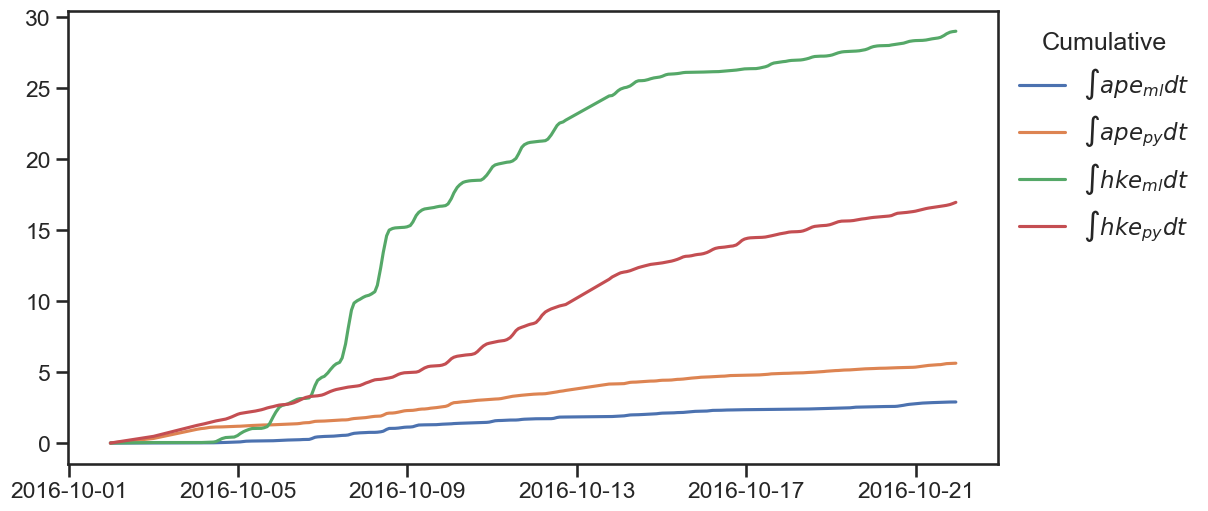

In [1109]:
plt.plot(subset.time, xrscipy.integrate.cumtrapz( subset.ape_prime_ml.fillna(0), coord='diff', initial =0)/1000, label='$\int ape_{ml} dt$')
plt.plot(subset.time, xrscipy.integrate.cumtrapz( subset.ape_prime_py.fillna(0), coord='diff', initial =0)/1000, label='$\int ape_{py} dt$' )

plt.plot(subset.time, xrscipy.integrate.cumtrapz( subset.hke_prime_ml.fillna(0), coord='diff', initial =0)/1000 , label='$\int hke_{ml} dt$');
plt.plot(subset.time, xrscipy.integrate.cumtrapz( subset.hke_prime_py.fillna(0), coord='diff', initial =0)/1000 , label='$\int hke_{py} dt$');

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Cumulative');

In [1110]:
subset = subset.swap_dims({'diff':'time'})

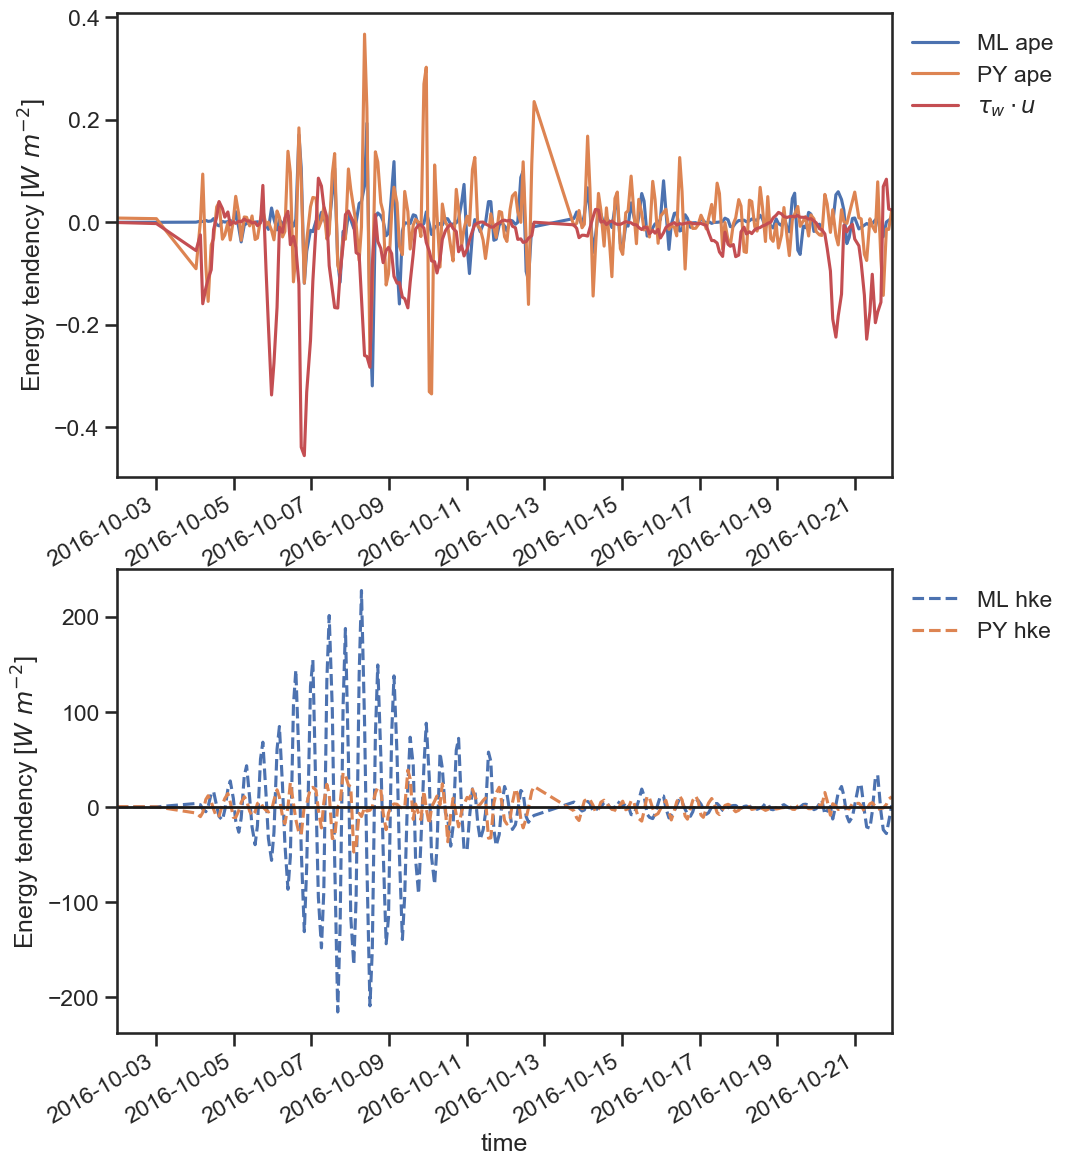

In [1360]:
f = plt.figure(figsize=(10,15))
ax = f.add_subplot(2,1,1)
subset.ape_ml.differentiate('time',datetime_unit='s').plot(label=r'ML ape', ax=ax)
subset.ape_py.differentiate('time',datetime_unit='s').plot(label=r'PY ape', ax=ax)
taudotu_series.apply(lambda x: x*1).plot(color='r',ax=ax,label=r'$\tau_w \cdot u$')
# subset.eps_ml.plot(label=r'ML eps',ax=ax)
# subset.eps_py.plot(label=r'PY eps',ax=ax)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1));
ax.set_ylabel('Energy tendency [$W~m^{-2}$]');
# ax.set_ylim(-1,1)

ax = f.add_subplot(2,1,2,sharex=ax)
subset.hke_ml.differentiate('time',datetime_unit='s').plot(label=r'ML hke',linestyle='dashed', ax=ax)
subset.hke_py.differentiate('time',datetime_unit='s').plot(label=r'PY hke',linestyle='dashed', ax=ax)
# taudotu_series.apply(lambda x: x*1).plot(color='r',ax=ax,label=r'$\tau_w \cdot u$')
# subset.eps_ml.plot(label=r'ML eps',ax=ax)
# subset.eps_py.plot(label=r'PY eps',ax=ax)
ax.set_ylabel('Energy tendency [$W~m^{-2}$]');

ax.axhline(0, color='k',lw=2)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1));

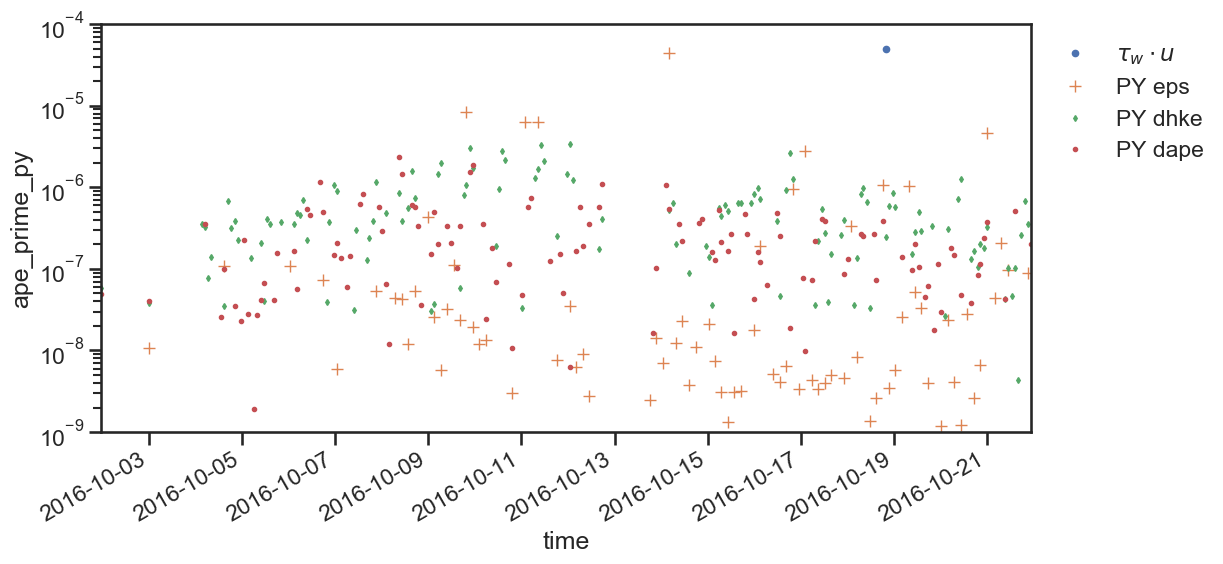

In [1114]:
taudotu_series.plot(label=r'$\tau_w \cdot u$', marker='.',lw=0)

# subset.eps_ml.pipe(np.abs).plot(label=r'ML eps',marker='+',lw=0, ms=8)
subset.eps_py.pipe(np.abs).plot(label=r'PY eps',marker='+',lw=0, ms=8)

# subset.hke_prime_ml.differentiate('time',datetime_unit='s').plot(label=r'ML dhke', marker='d',lw=0, ms=3)
subset.hke_prime_py.differentiate('time',datetime_unit='s').plot(label=r'PY dhke', marker='d',lw=0, ms=3)

# subset.ape_prime_ml.differentiate('time',datetime_unit='s').plot(label=r'ML dape', marker='o',lw=0, ms=3)
subset.ape_prime_py.differentiate('time',datetime_unit='s').plot(label=r'PY dape', marker='o',lw=0, ms=3)

plt.ylim(1e-9,1e-4)
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1));

In [1349]:
def integrate_in_time(subset,array):
    datetime = pd.to_datetime( subset.time.values )
    diff = datetime - datetime[0]
    subset['diff'] = ('time',diff.total_seconds())
    subset = subset.swap_dims({'time':'diff'})
    subset[array+'_int'] = xrscipy.integrate.cumtrapz( subset[array].fillna(0), coord='diff')
    subset = subset.swap_dims({'diff':'time'})
    return subset[array+'_int'] 

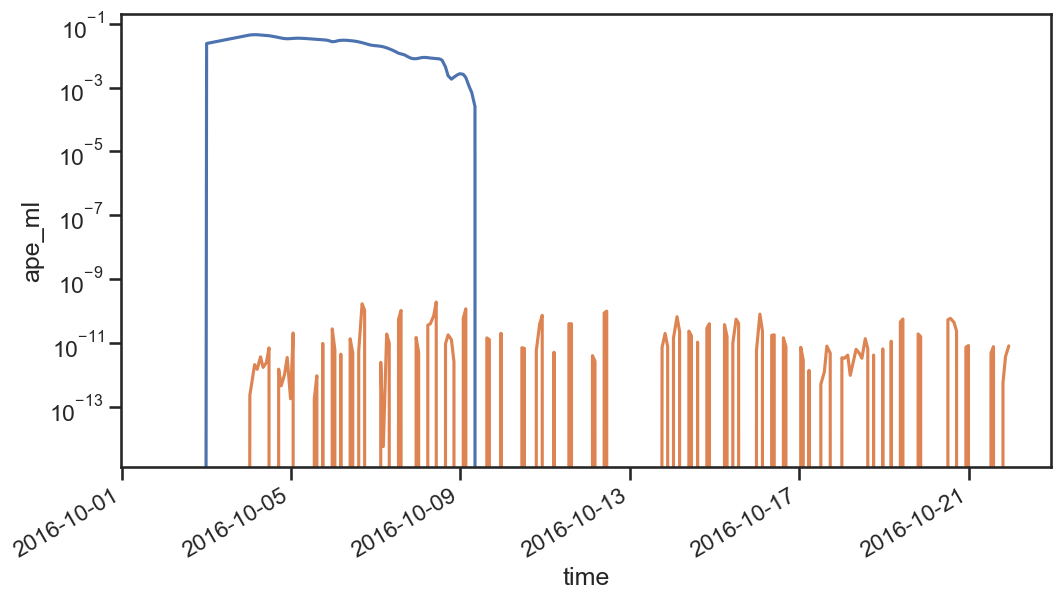

In [1355]:
# subset.B.plot()
integrate_in_time(subset,'B').plot()
subset.ape_ml.differentiate('time').plot()

plt.yscale('log')